The goal here is to analyze gene and gene-family specific GC content and see if the two peak pattern is observed 

In [25]:
#Now, we need to keep only species level genomes. 
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandarallel import pandarallel
import re  

pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
#determine which genomes to use, by taking unique species - for each species, find 1. the most recent genome, 2. the genome with the most genes 
genome_metadata = pd.read_csv('data/taxonomy_info.csv',header=0)
print(genome_metadata.head())

def clean_species_name(name):
    """
    Remove taxonomic qualifiers and return the first two valid words.
    """
    specifiers = {"x.", "sp.", "var.", "subsp.", "f.", "spp.", "cf.", "aff.", "ex"}
    words = name.split()
    cleaned_words = [w for w in words if w.lower().strip(".") not in specifiers]
    return " ".join(cleaned_words[:2]) if len(cleaned_words) >= 2 else " ".join(cleaned_words)

def get_lui_and_species(organism_name, accession_id):
    species = clean_species_name(organism_name)
    lui = f"{accession_id}_{species.replace(' ', '')}"  # Remove space in LUI
    return lui, species

def alphanum_only(s):
    return re.sub(r'[^A-Za-z0-9]', '', s)

# Add LUI and species columns
genome_metadata["LUI"], genome_metadata["Species"] = zip(*genome_metadata.apply(
    lambda row: get_lui_and_species(row["Organism"], row["ID"]),
    axis=1
))
genome_metadata["LUI"] = genome_metadata["LUI"].apply(alphanum_only)
genome_metadata["Species"] = genome_metadata["Species"].apply(alphanum_only)

# how many unique species are there?
unique_species = genome_metadata['Species'].unique()
print(f"Number of unique species: {len(unique_species)}")

#table() of sequencingTech
print(genome_metadata['SequencingTech'].value_counts())

print(genome_metadata['Year'].value_counts())

           ID                 Organism  \
0  OP952633.1  Aleuritopteris squamosa   
1  PV817907.1           Allium prattii   
2  PV817906.1           Allium prattii   
3  PV817905.1           Allium prattii   
4  PV817904.1           Allium prattii   

                                            Taxonomy  Year SequencingTech  
0  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2023        Unknown  
1  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown  
2  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown  
3  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown  
4  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown  
Number of unique species: 18350
SequencingTech
Unknown     52751
Illumina        5
PacBio          2
Name: count, dtype: int64
Year
2023    18314
2024     9669
2022     6979
2021     5096
2025     3466
2020     3219
2019     2175
2018     1182
2017     1067
2016      729
2015      362
2014 

In [27]:
print(genome_metadata.head())

           ID                 Organism  \
0  OP952633.1  Aleuritopteris squamosa   
1  PV817907.1           Allium prattii   
2  PV817906.1           Allium prattii   
3  PV817905.1           Allium prattii   
4  PV817904.1           Allium prattii   

                                            Taxonomy  Year SequencingTech  \
0  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2023        Unknown   
1  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown   
2  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown   
3  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown   
4  Eukaryota; Viridiplantae; Streptophyta; Embryo...  2025        Unknown   

                               LUI                 Species  
0  OP9526331Aleuritopterissquamosa  Aleuritopterissquamosa  
1           PV8179071Alliumprattii           Alliumprattii  
2           PV8179061Alliumprattii           Alliumprattii  
3           PV8179051Alliumprattii      

In [ ]:
#determine which genomes to use, by taking unique species - for each species, find 1. the most recent genome, 2. the genome with the most genes
#how many poaceae are there? how many times does this keyword appear in the metadata taxonomy column?
poaceae_count = genome_metadata['Taxonomy'].str.contains('poaceae', case=False, na=False).sum()
print(f"Number of Poaceae species: {poaceae_count}")

fabaceae_count = genome_metadata['Taxonomy'].str.contains('fabaceae', case=False, na=False).sum()
print(f"Number of fabaceae species: {fabaceae_count}")

for species in unique_species:
    species_genomes = genome_metadata[genome_metadata['Species'] == species]
    # is there one genome that is most recent for this species?
    #get the species with the most recent year, 
    #what's the most recent year for this species?
    species_genomes['Year'].value_counts()
    #how many times does the most recent year appear?
    most_recent_year_count = species_genomes['Year'].value_counts().max()

    #most_recent_genome = species_genomes.loc[species_genomes['Year'].idxmax()]

_IncompleteInputError: incomplete input (2000851407.py, line 19)

In [30]:
from src.get_genome_quantifications import *
import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
gbfs_dir = "data/gbfs"

#first, produce a new dataset where LUIs are found in the gbfs_dir
genome_metadata['LUI_in_gbfs'] = genome_metadata['LUI'].apply(
    lambda lui: os.path.exists(os.path.join(gbfs_dir, f"{lui}.gbf.fixed"))
)

#how many does this return?
lui_in_gbfs_count = genome_metadata['LUI_in_gbfs'].sum()
print(f"Number of LUIs found in gbfs directory: {lui_in_gbfs_count}")

#make the small df for these genomes
genome_metadata_gbfs = genome_metadata[genome_metadata['LUI_in_gbfs']]

#what are all the genes found in these genomes? 
LUIs = genome_metadata_gbfs['LUI'].tolist()

def extract_all_genes_DNA(lui_list, gbf_dir):
    """
    Extract all protein-coding gene sequences (CDS translations) for given LUIs.
    """
    all_genes = {}
    gbf_files = [f for f in os.listdir(gbf_dir) if f.endswith(".gbf.fixed") and f.split(".")[0] in lui_list]
    print(gbf_files)
    for gbf_file in tqdm(gbf_files):
        gbf_path = os.path.join(gbf_dir, gbf_file)
        with open(gbf_path, "r") as handle:
            for record in SeqIO.parse(handle, "genbank"):
                for feature in record.features:
                    if feature.type == "gene":
                        gene_name = feature.qualifiers.get("gene", ["Unknown"])[0]
                        dna_sequence = str(feature.location.extract(record.seq))
                        
                        LUI = gbf_file.split(".")[0]
                        header = f"{LUI}_{gene_name}"

                        if gene_name not in all_genes:
                            all_genes[gene_name] = {}

                        all_genes[gene_name][header] = dna_sequence

    #chains into, 
    return all_genes

all_genes = extract_all_genes_DNA(LUIs, gbfs_dir)

# Convert the dictionary to a DataFrame
all_genes_df = pd.DataFrame.from_dict(all_genes, orient='index').transpose
#split the header into LUI and gene name
all_genes_df.columns = pd.MultiIndex.from_tuples([tuple(col.split('_', 1)) for col in all_genes_df.columns], names=['LUI', 'Gene'])

print(all_genes_df.head())

Number of LUIs found in gbfs directory: 12547
['NC0081151Eucalyptusglobulus.gbf.fixed', 'NC0009251Porphyrapurpurea.gbf.fixed', 'NC0081161Staurastrumpunctulatum.gbf.fixed', 'NC0009261Guillardiatheta.gbf.fixed', 'NC0071441Cucumissativus.gbf.fixed', 'NC0009271Nephroselmisolivacea.gbf.fixed', 'NC0068611Huperzialucidula.gbf.fixed', 'NC0009321Arabidopsisthaliana.gbf.fixed', 'NC0072881Emilianiahuxleyi.gbf.fixed', 'NC0013191Marchantiapaleacea.gbf.fixed', 'NC0074991Phalaenopsisaphrodite.gbf.fixed', 'NC0015681Epifagusvirginiana.gbf.fixed', 'NC0081171Zygnemacircumcarinatum.gbf.fixed', 'NC0016032Euglenagracilis.gbf.fixed', 'NC0081551Oryzasativa.gbf.fixed', 'NC0016311Pinusthunbergii.gbf.fixed', 'NC0085901Hordeumvulgare.gbf.fixed', 'NC0016662Zeamays.gbf.fixed', 'NC0082351Populusalba.gbf.fixed', 'NC0075001Nicotianasylvestris.gbf.fixed', 'NC0018401Cyanidiumcaldarium.gbf.fixed', 'NC0082891Ostreococcustauri.gbf.fixed', 'NC0018651Chlorellavulgaris.gbf.fixed', 'NC0083251Daucuscarota.gbf.fixed', 'NC0021861

100%|██████████| 12547/12547 [01:31<00:00, 137.64it/s]


AttributeError: 'function' object has no attribute 'columns'

In [32]:
rows = []
for gene, sample_seq_dict in tqdm(all_genes.items()):
    for sample_gene, seq in sample_seq_dict.items():
        rows.append({
            'sample': sample_gene,
            'gene': gene,
            'seq': seq
        })

df = pd.DataFrame(rows)

print(df.head())

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [00:00<00:00, 195.00it/s]


                                     sample      gene  \
0      NC0081151Eucalyptusglobulus_trnH-GUG  trnH-GUG   
1        NC0009251Porphyrapurpurea_trnH-GUG  trnH-GUG   
2  NC0081161Staurastrumpunctulatum_trnH-GUG  trnH-GUG   
3         NC0009261Guillardiatheta_trnH-GUG  trnH-GUG   
4          NC0071441Cucumissativus_trnH-GUG  trnH-GUG   

                                                 seq  
0  GCGGATGTAGCCAAGTGGATCAAGGCAGTGGATTGTGAATCCACCA...  
1  GCGAGTGTGGCCAAGGGGTTAAGGCAATGGGTTGTGGCTCCATCAT...  
2  GCGGACGTGGCCAAGTGGTTAAGGCAGTGGATTGTGATTCCGTGAT...  
3  GGCGAGTGTAGCCAAGTGGTTACGGCAGCGGGTTGTGGTTCCGTTA...  
4  GCGGATGTAGCCAAGTGGATCAAGGCAGTGGATTGTGAATCCACCA...  


In [33]:
#apply get_gc function to the seq column and save it in a new column
#get_gc is in the environment
df['gc_content'] = df['seq'].progress_apply(get_gc)

100%|██████████| 1263005/1263005 [00:06<00:00, 188194.47it/s]


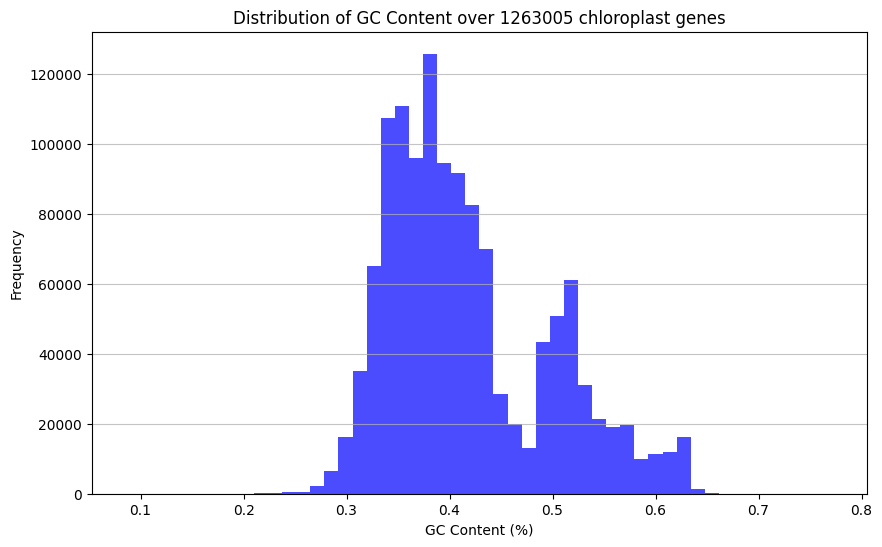

In [35]:
#plot a histogram of the GC content
plt.figure(figsize=(10, 6))
plt.hist(df['gc_content'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of GC Content over 1263005 chloroplast genes')
plt.xlabel('GC Content (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

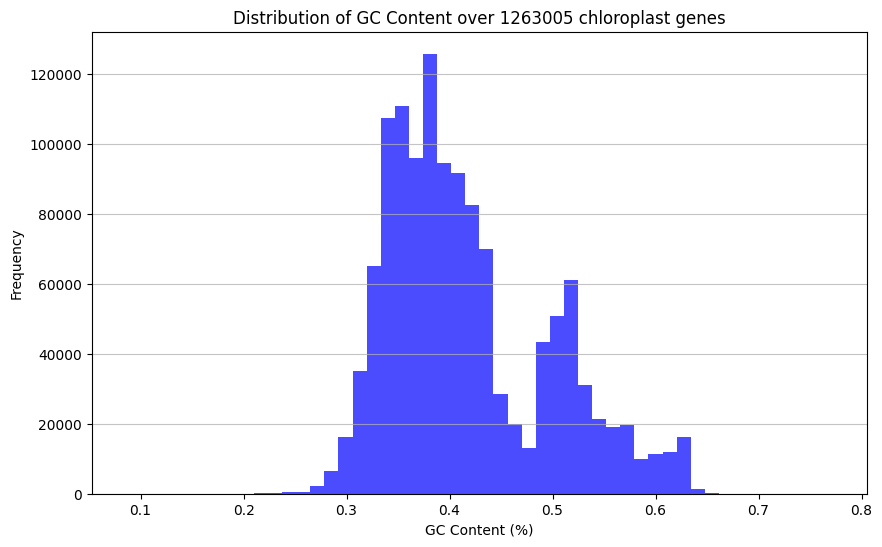

In [36]:
#plot a histogram of the GC content
plt.figure(figsize=(10, 6))
plt.hist(df['gc_content'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of GC Content over 1263005 chloroplast genes')
plt.xlabel('GC Content (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [37]:
#write the df to a csv file
df.to_csv('data/chloroplast_genes_gc_content.csv', index=False)

Genome length: 140384 bp


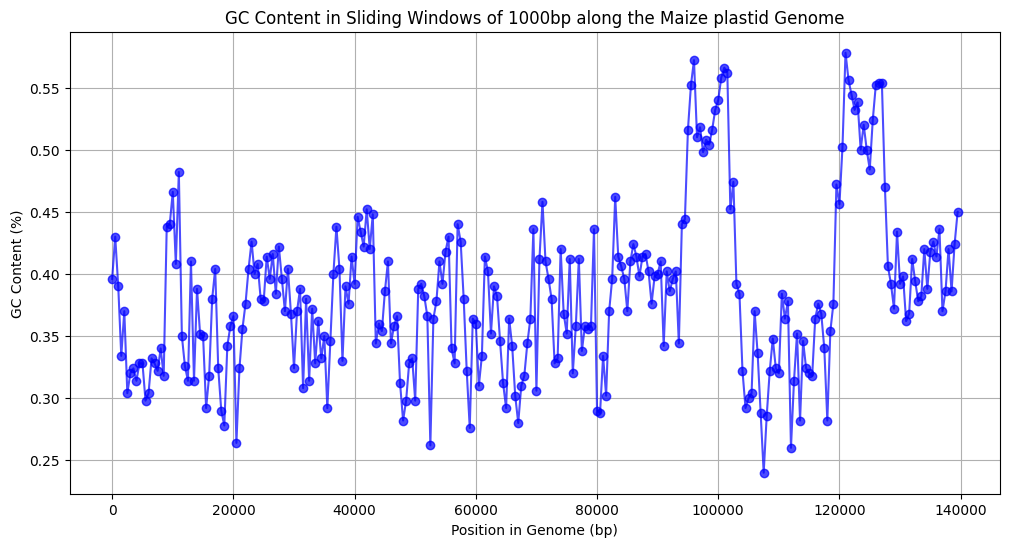

In [28]:
#now, let's plot GC content in a sliding window of 1000bp along the genome
genome_file = "/workdir/hdd29/chloroplast_genome_evaluation/data/genomes/NC0016662.fa"

from Bio import SeqIO
from Bio import SeqUtils
import matplotlib.pyplot as plt

def calculate_sliding_window_gc(genome_file, window_size=1000):
    """
    Calculate GC content in a sliding window along the genome.
    """
    genome_seq = SeqIO.read(genome_file, "fasta").seq
    print(f"Genome length: {len(genome_seq)} bp")
    gc_content = []
    
    for i in range(0, len(genome_seq) - window_size + 1, window_size):
        window_seq = genome_seq[i:i + window_size]
        gc_content.append(SeqUtils.gc_fraction(window_seq))
    
    return gc_content

gc_content = calculate_sliding_window_gc(genome_file, window_size=500)
plt.figure(figsize=(12, 6))
plt.plot(range(0, len(gc_content) * 500, 500),
            gc_content, marker='o', linestyle='-', color='blue', alpha=0.7)
plt.title('GC Content in Sliding Windows of 1000bp along the Maize plastid Genome')
plt.xlabel('Position in Genome (bp)')
plt.ylabel('GC Content (%)')
plt.grid()
plt.show()


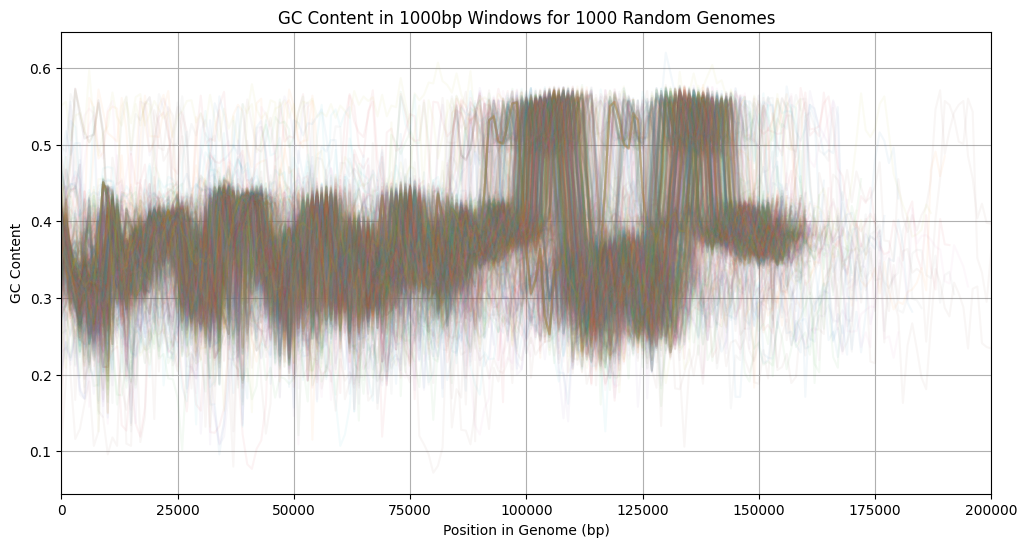

In [24]:
import random, glob
from Bio import SeqIO, SeqUtils
import matplotlib.pyplot as plt

genome_dir = "/workdir/hdd29/chloroplast_genome_evaluation/data/genomes/*.fa"
genome_files = random.sample(glob.glob(genome_dir), 1000)

def calculate_sliding_window_gc(genome_file, window_size=1000):
    seq = SeqIO.read(genome_file, "fasta").seq
    return [SeqUtils.gc_fraction(seq[i:i+window_size])
            for i in range(0, len(seq)-window_size+1, window_size)]

plt.figure(figsize=(12, 6))
for f in genome_files:
    gc = calculate_sliding_window_gc(f, window_size=1000)
    plt.plot(range(0, len(gc)*1000, 1000), gc, alpha=0.05   )
plt.title("GC Content in 1000bp Windows for 1000 Random Genomes")
plt.xlabel("Position in Genome (bp)")
plt.ylabel("GC Content")
plt.xlim(0, 200000)
plt.grid()
plt.show()